# ECE 661 Final Project: Adversarial Patch Attacks
### Jamie Liu, Hiep Nguyen, & Jack Parker

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import torchvision.transforms.functional as TF
import random
import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Load data

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Load dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training data into training and validation sets
train_set, val_set = random_split(train_data, [40000, 10000])

# Define dataloaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## Define helper functions to be used during experiments

In [ ]:
# This function evaluates a model's accuracy on the validation set
# Optionally, one can pass an adversarial patch as an argument to evaluate the model's performance against a patch attack
def eval(model, patch=None, target_class=None, extension=False):
  # Stats to use to calculate accuracy after the eval loop
  total_correct = 0
  total = 0
  total_target = 0
  # Put model on GPU and switch to eval mode
  model = model.to(device)
  model.eval()
  # Evaluation loop
  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(val_loader):
      # Put data on GPU
      images = images.to(device)
      if patch is not None:
        images = apply(patch, images, extension=extension)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      predictions = torch.argmax(predictions, dim=1)
      # Update validation accuracy information
      total += len(images)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
      if target_class is not None:
        target = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
        num_target = (predictions == target).float().sum().item()
        total_target += num_target
  # If evaluating the effects of a targeted patch attach, it is nice to see whether or not the model is classifying lots of examples to the target class
  if target_class is not None:
    target_percentage = total_target / total
    print(f"Percentage of samples predicted as target class {target_class}: {100 * target_percentage}")
  # Calculate accuracy
  accuracy = total_correct / total
  return accuracy

In [ ]:
# This function is designed to take in a pretrained ResNet model and fine-tune its weights for the CIFAR-10 dataset
# The idea is to fine-tune ResNet for the CIFAR-10 dataset (accuracy should be around 82%) and then degrade that performance via an adversarial patch attack
def fine_tune_for_cifar10(model, num_epochs=30, model_path="resnet18.pth", lr=0.01):
  # Put model on GPU and put model in training mode
  model = model.to(device)
  model.train()
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.2)
  best_accuracy = 0.0
  best_model_path = model_path
  # Training loop
  for i in range(num_epochs):
    # Stats to use for calculating accuracy
    total_correct = 0
    total = 0
    # Iterate through each batch of data
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on GPU
      images = images.to(device)
      labels = labels.to(device)
      # Make predictions
      predictions = model(images)
      # Calculate loss for the batch
      loss = criterion(predictions, labels)
      # Gradient descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Update training accuracy information
      total += len(images)
      predictions = torch.argmax(predictions, dim=1)
      num_correct = (predictions == labels).float().sum().item()
      total_correct += num_correct
    scheduler.step()  # Update the learning rate

    # Print training accuracy
    print(f"Epoch {str(i + 1)}: Training accuracy = {str(total_correct / total)}")
    # Print validation accuracy
    val_accuracy = eval(model, patch=None, target_class=None)
    print(f"Validation accuracy: {str(val_accuracy)}")

    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      torch.save(model.state_dict(), best_model_path)
      print(f"Saved new best model with accuracy: {best_accuracy:.4f}")

In [ ]:
# Apply patch to a batch of images
def apply(patch, batch_of_images, extension=False):
  num_images = batch_of_images.shape[0]
  patch_size = patch.shape[1]
  # Iterate through each image in the batch
  for i in range(num_images):
    # Rotate the patch by a random number of degrees
    degree = random.uniform(0, 360)
    patch = TF.rotate(patch, angle=degree)
    # If doing the extension, apply some more transformations
    if extension:
      # Apply horizontal flip with 50% probability
      if random.random() > 0.5:
        patch = TF.hflip(patch)
      # Apply vertical flip with 50% probability
      if random.random() > 0.5:
        patch = TF.vflip(patch)
      # Apply color inversion with 50% probability
      if random.random() > 0.5:
        patch = TF.invert(patch)
    # Randomly choose an (x, y) coordinate on the 32x32 CIFAR-10 image
    # This coordinate will be where the top left corner of the rotated patch goes
    top_left_x = random.randint(0, 31 - patch_size)
    top_left_y = random.randint(0, 31 - patch_size)
    # Apply the randomly rotated patch at the random location
    batch_of_images[i, :, top_left_x:top_left_x+patch_size, top_left_y:top_left_y+patch_size] = patch
  return batch_of_images

In [ ]:
# Function to load the best model checkpoint
def load_model(model, path, device="cuda"):
    model.load_state_dict(torch.load(path, map_location=device))
    model = model.to(device)
    return model

In [ ]:
# This function fine-tunes an adversarial patch against a provided whitebox model
# Model accuracy against the patch attack is reported at each step
def generate_adversarial_patch(model, patch_size, target_class=None, num_epochs=5, lr=1e-1, momentum=0.8, extension=False):
  model = model.to(device)
  model.eval()
  # Initialize patch to all zeros
  patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)
  optimizer = optim.SGD([patch], lr, momentum)
  criterion = nn.CrossEntropyLoss()
  # Optimize the patch
  for i in range(num_epochs):
    print(f"Epoch {str(i + 1)}")
    for batch_idx, (images, labels) in enumerate(train_loader):
      # Put data on the GPU
      images = images.to(device)
      labels = labels.to(device)
      # Apply the patch at a random location and with a random rotation for each image in the batch
      images = apply(patch, images, extension=extension)
      # Make predictions on the patched images
      predictions = resnet18(images)
      # For an untargeted attack, create false labels by incrementing the true labels by 1
      if target_class is None:
        false_labels = (labels + 1) % 10
      # For a targeted attack, set all the false labels to the target class
      else:
        false_labels = torch.zeros(len(images), dtype=torch.long).fill_(target_class).to(device)
      # Tune the patch
      loss = criterion(predictions, false_labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # See how the patch performs
    print(f"Target class: {target_class}")
    accuracy = eval(model, patch=patch, target_class=target_class)
    print(f"Accuracy: {str(accuracy)}\n")
  return patch

In [ ]:
# This function test the model accuracy on clean test dataset
# Optinally, if pass in an adversarial patch, this function test model accuracy, untargetted and targetted ASR
def test(model, patch=None, target_class=None, extension=False):
  model.eval()
  total = 0
  total_correct = 0
  total_misclassified = 0
  total_targeted_hits = 0

  with torch.no_grad():
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      if patch is not None:
        images = apply(patch, images, extension=extension)

      outputs = model(images)
      predictions = torch.argmax(outputs, dim=1)
      total += labels.size(0)
      total_correct += (predictions == labels).sum().item()
      total_misclassified += (predictions != labels).sum().item()

      if target_class is not None:
        targeted_misclassifications = ((predictions != labels) & (predictions == target_class))
        total_targeted_hits += targeted_misclassifications.sum().item()

  adversarial_accuracy = total_correct / total
  untargeted_attack_rate = total_misclassified / total

  if patch is not None:
    print(f"Model accuracy with adversarial patch: {adversarial_accuracy * 100:.2f}%")
    print(f"Untargeted attack success rate on test set: {untargeted_attack_rate * 100:.2f}%")
  else:
    print(f"Model accuracy on clean test set: {adversarial_accuracy * 100:.2f}%")

  if target_class is not None:
    targeted_attack_rate = total_targeted_hits / total
    print(f"Targeted attack success rate on test set for class {target_class}: {targeted_attack_rate * 100:.2f}%")
    return adversarial_accuracy, untargeted_attack_rate, targeted_attack_rate
  else:
    return adversarial_accuracy, untargeted_attack_rate

In [ ]:
# This function takes in a patch and outputs it visually
def visualize_patch(patch):
    patch = patch.detach()
    patch = (patch - patch.min()) / (patch.max() - patch.min())  # Normalize to [0, 1]

    # Convert to numpy and transpose dimensions from [C, H, W] to [H, W, C] for visualization
    patch_np = patch.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(patch_np)
    plt.axis('off')
    plt.show()


In [ ]:
# This function is used to plot the (untargeted or targeted) ASR v.s. patch size
def plot_asr_vs_patch_size(patch_sizes, asr_results):
    asr_values = [asr_results[size] * 100 for size in patch_sizes]
    plt.figure(figsize=(6,4))
    plt.plot(patch_sizes, asr_values, marker='o', linestyle='-', color='b')
    plt.title('Attack Success Rate vs Patch Size')
    plt.xlabel('Patch Size (pixels)')
    plt.ylabel('ASR (%)')
    plt.grid(True)
    plt.xticks(patch_sizes)
    plt.show()


## Fine-tune ResNet18 for CIFAR-10

In [ ]:
# Load pre-trained model
resnet18 = models.resnet18(weights="DEFAULT")

# ResNet is trained on ImageNet, which has 1000 classes
# So we need to modify the output layer for CIFAR-10, which has 10 classes
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

# Finetune the model
# fine_tune_for_cifar10(model=resnet18, num_epochs=30, model_path="resnet18.pth")

# Load best model checkpoint
resnet18 = load_model(resnet18, "resnet18.pth", device=device)

# Test model performance on clean test dataset
test(model=resnet18, patch=None, target_class=None)

Model accuracy on clean test set: 83.15%


(0.8315, 0.1685)

## Experiment 1: Untargeted 8x8 patch attack on ResNet18

Epoch 1
Target class: None
Accuracy: 0.4572

Epoch 2
Target class: None
Accuracy: 0.4038

Epoch 3
Target class: None
Accuracy: 0.3856

Epoch 4
Target class: None
Accuracy: 0.373

Epoch 5
Target class: None
Accuracy: 0.3715



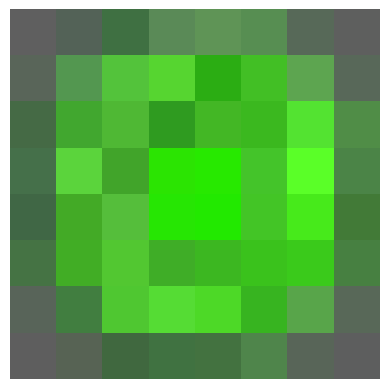

Model accuracy with adversarial patch: 39.89%
Untargeted attack success rate on test set: 60.11%


(0.3989, 0.6011)

In [ ]:
# Generate adversarial patch
patch_untargeted_size8 = generate_adversarial_patch(model=resnet18, patch_size=8)

# Visualize the generated patch
visualize_patch(patch_untargeted_size8)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untargeted_size8)

## Experiment 2: The effect of patch size on untargeted attack success rate for ResNet18

In [ ]:
# Calculate untargeteded ASR for patches of various sizes and plot patch size vs. untargeted ASR
patch_sizes = [3, 5, 7, 16]
untargetted_asr_results = {}

for size in patch_sizes:
  patch = generate_adversarial_patch(model=resnet18, patch_size=size)
  visualize_patch(patch)
  adversarial_accuracy, untargetted_asr = test(model=resnet18, patch=patch)
  untargetted_asr_results[size] = untargetted_asr

plot_asr_vs_patch_size(patch_sizes, untargetted_asr_results)

## Experiment 3: Targeted patch attacks

Epoch 1
Target class: 5
Percentage of samples predicted as target class 5: 53.11
Accuracy: 0.2651

Epoch 2
Target class: 5
Percentage of samples predicted as target class 5: 55.67999999999999
Accuracy: 0.2407

Epoch 3
Target class: 5
Percentage of samples predicted as target class 5: 55.53
Accuracy: 0.2364

Epoch 4
Target class: 5
Percentage of samples predicted as target class 5: 54.50000000000001
Accuracy: 0.2258

Epoch 5
Target class: 5
Percentage of samples predicted as target class 5: 53.99
Accuracy: 0.2217



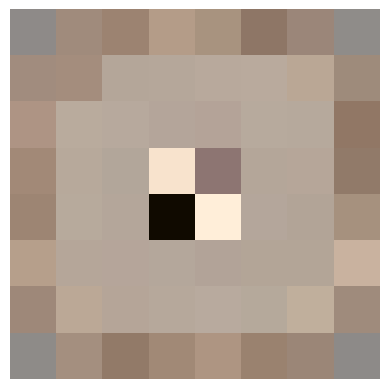

Model accuracy with adversarial patch: 25.07%
Untargeted attack success rate on test set: 74.93%
Targeted attack success rate on test set for class 5: 43.72%


(0.2507, 0.7493, 0.4372)

In [ ]:
# Generate targeted adversarial patch
patch_targeted_size8 = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5)

# Visualize the generated patch
visualize_patch(patch_targeted_size8)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_targeted_size8, target_class=5)

In [ ]:
def plot_targeted_asr_vs_patch_size(model, target_class):
  print(f"\nRUNNING EXPERIMENTS FOR TARGET CLASS {target_class}\n")
  patch_sizes = [3, 5, 7, 16]
  targetted_asr_results = {}
  for size in patch_sizes:
    patch = generate_adversarial_patch(model=model, patch_size=size, target_class=target_class)
    visualize_patch(patch)
    adversarial_accuracy, untargetted_asr, targetted_asr = test(model=resnet18, patch=patch, target_class=target_class)
    targetted_asr_results[size] = targetted_asr
  plot_asr_vs_patch_size(patch_sizes, targetted_asr_results)

In [ ]:
for target_class in range(10):
  plot_targeted_asr_vs_patch_size(resnet18, target_class=target_class)

## Experiment 4: Transferring patches to other models

In [ ]:
s = "\n----------------------------------------------------------------------------------------\n"
# Load ResNet50 and test
resnet50 = models.resnet50(weights="DEFAULT")
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)
resnet50 = load_model(resnet50, "resnet50.pth", device=device)
test(model=resnet50, patch=None, target_class=None)
print(s)

# Untargeted Attack
test(model=resnet50, patch=patch_untargeted_size8, target_class=None)
print(s)

# Targeted Attack
test(model=resnet50, patch=patch_targeted_size8, target_class=5)
print(s)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.2MB/s]


Model accuracy on clean test set: 86.81%

----------------------------------------------------------------------------------------

Model accuracy with adversarial patch: 37.04%
Untargeted attack success rate on test set: 62.96%

----------------------------------------------------------------------------------------

Model accuracy with adversarial patch: 54.52%
Untargeted attack success rate on test set: 45.48%
Targeted attack success rate on test set for class 5: 12.07%

----------------------------------------------------------------------------------------



In [ ]:
# Load VGG19 and test
vgg19 = models.vgg19(weights="DEFAULT")
num_features = vgg19.classifier[-1].in_features
vgg19.classifier[-1] = nn.Linear(num_features, 10)
vgg19 = load_model(vgg19, "vgg19.pth")
test(model=vgg19, patch=None, target_class=None)
print(s)

# Untargeted Attack
test(model=vgg19, patch=patch_untargeted_size8, target_class=None)
print(s)

# Targeted Attack
test(model=vgg19, patch=patch_targeted_size8, target_class=5)
print(s)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 79.0MB/s]


Model accuracy on clean test set: 88.43%

----------------------------------------------------------------------------------------

Model accuracy with adversarial patch: 65.37%
Untargeted attack success rate on test set: 34.63%

----------------------------------------------------------------------------------------

Model accuracy with adversarial patch: 38.69%
Untargeted attack success rate on test set: 61.31%
Targeted attack success rate on test set for class 5: 7.49%

----------------------------------------------------------------------------------------



In [ ]:
# Load DenseNet121 and test
densenet121 = models.densenet121(weights="DEFAULT")
num_features = densenet121.classifier.in_features
densenet121.classifier = nn.Linear(num_features, 10)
densenet121 = load_model(densenet121, "densenet121.pth")
test(model=densenet121, patch=None, target_class=None)
print(s)

# Untargeted Attack
test(model=densenet121, patch=patch_untargeted_size8, target_class=None)
print(s)

# Targeted Attack
test(model=densenet121, patch=patch_targeted_size8, target_class=5)
print(s)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 89.5MB/s]


Model accuracy on clean test set: 70.08%

----------------------------------------------------------------------------------------

Model accuracy with adversarial patch: 60.78%
Untargeted attack success rate on test set: 39.22%

----------------------------------------------------------------------------------------

Model accuracy with adversarial patch: 54.30%
Untargeted attack success rate on test set: 45.70%
Targeted attack success rate on test set for class 5: 10.86%

----------------------------------------------------------------------------------------



## Experiment 5 (Extension): Creating patches that are robust to more transformations

Epoch 1
Target class: None
Accuracy: 0.3849

Epoch 2
Target class: None
Accuracy: 0.3884

Epoch 3
Target class: None
Accuracy: 0.3672

Epoch 4
Target class: None
Accuracy: 0.3576

Epoch 5
Target class: None
Accuracy: 0.3617



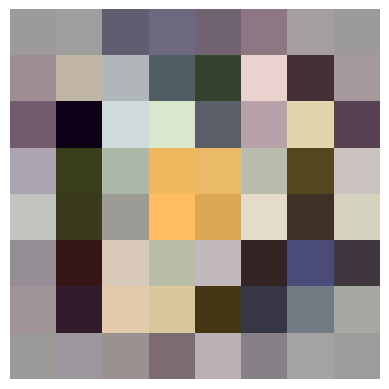

Model accuracy with adversarial patch: 38.16%
Untargeted attack success rate on test set: 61.84%


(0.3816, 0.6184)

In [ ]:
# Generate adversarial patch
patch_untargeted_extension = generate_adversarial_patch(model=resnet18, patch_size=8, extension=True)

# Visualize the generated patch
visualize_patch(patch_untargeted_extension)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_untargeted_extension, target_class=None, extension=True)

In [ ]:
# Generate adversarial patch
patch_targeted_extension = generate_adversarial_patch(model=resnet18, patch_size=8, target_class=5, extension=True)

# Visualize the generated patch
visualize_patch(patch_targeted_extension)

# Test adversarial success rate on test dataset
test(model=resnet18, patch=patch_targeted_extension, target_class=5, extension=True)

In [ ]:
# Test how Type C patches transfer to ResNet50
# Untargeted Attack
test(model=resnet50, patch=patch_untargeted_extension, target_class=None, extension=True)
print(s)

# Targeted Attack
test(model=resnet50, patch=patch_targeted_extension, target_class=5, extension=True)
print(s)

In [ ]:
# Test how Type C patches transfer to VGG19
# Untargeted Attack
test(model=vgg19, patch=patch_untargeted_extension, target_class=None, extension=True)
print(s)

# Targeted Attack
test(model=vgg19, patch=patch_targeted_extension, target_class=5, extension=True)
print(s)

In [ ]:
# Test how Type C patches transfer to DenseNet121
# Untargeted Attack
test(model=densenet121, patch=patch_untargeted_extension, target_class=None, extension=True)
print(s)

# Targeted Attack
test(model=densenet121, patch=patch_targeted_extension, target_class=5, extension=True)
print(s)